# Аналитический отчет деятельности сервиса Яндекс.Афиша о продаже билетов за период 01.06.2024-31.10.2024

Автор проекта: Яфаров Ринат 22.04.2025-25.04.2025

В данном проекте будет проведен анализ данных о продажах билетов через сервис Яндекс Афиша с целью выявления изменений в пользовательском спросе. Проект инициирован командой продуктового отдела, заметившей общие тенденции в изменении предпочтений пользователей, причины которых требуют выяснения. Анализ охватывает различные аспекты данных, включая категории событий, выручку, продажи билетов, поведение пользователей мобильных и стационарных устройств, организаторов и площадки.

**Цель:** Выявить и проанализировать изменения в пользовательском спросе на события сервиса Яндекс Афиша, определить причины этих изменений (сезонность, изменение аудитории, популярность конкретных событий/организаторов/площадок), и предоставить команде продуктового отдела информацию, необходимую для принятия обоснованных решений по улучшению сервиса и стратегий продвижения.

**Задачи:**
1. Провести предобработку и очистку данных, выявить пропуски и аномалии.
2. Исследовать распределение заказов по сегментам.
3. Исследовать сезонные изменения спроса на билеты.
4. Исследовать осеннюю активность пользователей.
5. Выявить наиболее популярные регионы, события и билетных партнёров.
6. Проверить статистические гипотезы о различиях в пользовательском поведении в разрезе мобильных и стационарных устройств.
7. Сформировать выводы.
8. Дать рекомендации.

## Описание данных
Датасет `final_tickets_orders_df.csv` включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных. Описание полей датасета:
* `order_id` — уникальный идентификатор заказа,
* `user_id` — уникальный идентификатор пользователя,
* `created_dt_msk` — дата создания заказа (московское время),
* `created_ts_msk` — дата и время создания заказа (московское время),
* `event_id` — идентификатор мероприятия из таблицы events,
* `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет',
* `age_limit` — возрастное ограничение мероприятия,
* `currency_code` — валюта оплаты, например rub для российских рублей,
* `device_type_canonical` — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных,
* `revenue` — выручка от заказа,
* `service_name` — название билетного оператора,
* `tickets_count` — количество купленных билетов,
* `total` — общая сумма заказа.

Датасет `final_tickets_events_df.csv` содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. Описание полей датасета:
* `event_id` — уникальный идентификатор мероприятия,
* `event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных,
* `event_type_description` — описание типа мероприятия,
* `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее,
* `organizers` — организаторы мероприятия,
* `region_name` — название региона,
* `city_name` — название города,
* `venue_id` — уникальный идентификатор площадки,
* `venue_name` — название площадки,
* `venue_address` — адрес площадки.

Датасет `final_tickets_tenge_df.csv` с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге. Содержит следующие поля:
* nominal — номинал (100 тенге).
* `data` — дата,
* `curs` — курс тенге к рублю,
* `cdx` — обозначение валюты (kzt).

## План работы
1. Загрузить данные и познакомиться с ними.
2. Провести предобработку данных и подготовить их к исследовательскому анализу.
3. Провести исследовательский анализ данных.
4. Провести статистический анализ данных.
5. Сформулировать общие выводы и рекомендации.

## Загрузка данных и знакомство с ними

Импортируем нужные для дальнейшей работы библиотеки:

In [1]:
# импорт библиотек для работы с данными
import numpy as np
import pandas as pd

# импорт библиотек для визуализации
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# импорт библиотеки для проверки гипотез
import scipy.stats as st

In [2]:
# загрузка датафреймов
orders_df = pd.read_csv("https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv")
events_df = pd.read_csv("https://code.s3.yandex.net/datasets/final_tickets_events_df.csv")
tenge_df = pd.read_csv("https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv")

Знакомимся с содержимым каждого датафрейма, выводим общую информацию:

In [4]:
# знакомство с датафреймом orders_df
display(orders_df.head())
display(orders_df.info())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

None

In [5]:
# знакомство с датафреймом events_df
display(events_df.head())
display(events_df.info())

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


None

In [6]:
# знакомство с датафреймом tenge_df
display(tenge_df.head())
display(tenge_df.info())

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


None

In [7]:
# сохранение размеров датафреймов
orders_shape = orders_df.shape
events_shape = events_df.shape
tenge_shape = tenge_df.shape

**Промежуточный вывод:**
1. orders_df: Датафрейм с информацией о заказах (290849 строк, 14 столбцов). Содержит пропущенные значения только в столбце `days_since_prev`. Необходимо преобразовать столбцы `created_dt_msk` и `created_ts_msk` из строкового формата в datetime.
2. events_df: Датафрейм с информацией о событиях (22427 строк, 11 столбцов). Пропущенные значения отсутствуют. Типы данных столбцов соответствуют их названиям.
3. tenge_df: Датафрейм с курсами тенге (357 строк, 4 столбца). Пропущенные значения отсутствуют. Требуется преобразовать столбец `data` из строкового формата в datetime. Рекомендуется отсортировать данные по дате и отфильтровать по диапазону с 01.06.2024 по 31.10.2024 для оптимизации хранения и скорости работы.

## Предобработка данных и подготовка к исследованию

### Проверка данных на пропуски

Проверим корректную выгрузку данных из SQL для каждого датафрейма:

In [8]:
# проверка датафрейма orders_df
orders_df.isna().sum()

order_id                     0
user_id                      0
created_dt_msk               0
created_ts_msk               0
event_id                     0
cinema_circuit               0
age_limit                    0
currency_code                0
device_type_canonical        0
revenue                      0
service_name                 0
tickets_count                0
total                        0
days_since_prev          21940
dtype: int64

In [9]:
# проверка датафрейма events_df
events_df.isna().sum()

event_id                  0
event_name                0
event_type_description    0
event_type_main           0
organizers                0
region_name               0
city_name                 0
city_id                   0
venue_id                  0
venue_name                0
venue_address             0
dtype: int64

In [10]:
# проверка датафрейма tenge_df
tenge_df.isna().sum()

data       0
nominal    0
curs       0
cdx        0
dtype: int64

### Изучение значений в ключевых столбцах

* Начнем с **категориальных данных**. Для каждого датафрейма выведем уникальные значения по столбцам:

In [11]:
# категориальные столбцы в датафрейме orders_df
for col in ['order_id', 'user_id', 'event_id', 'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical', 'service_name']:
    print(f"{col}:", orders_df[col].unique(), '\n')

order_id: [4359165 7965605 7292370 ... 8473772 5526067  813654] 

user_id: ['0002849b70a3ce2' '0005ca5e93f2cf4' '000898990054619' ...
 'fffcd3dde79eb2c' 'fffeeb3c120cf0b' 'ffff00725179321'] 

event_id: [169230 237325 578454 ... 300765 540339 568852] 

cinema_circuit: ['нет' 'Другое' 'Киномакс' 'КиноСити' 'Москино' 'ЦентрФильм'] 

age_limit: [16  0 18 12  6] 

currency_code: ['rub' 'kzt'] 

device_type_canonical: ['mobile' 'desktop'] 

service_name: ['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино билет' 'Цвет и билет' 'Зе Бест!'
 'Тех билет' 'Лимоны' 'Билеты в интернете'] 



In [12]:
# проверка на дубликаты
orders_df.duplicated().sum()

0

In [13]:
# категориальные столбцы в датафрейме events_df
for col in events_df.columns:
    print(f"{col}:", events_df[col].unique(), '\n')

event_id: [  4436   5785   8817 ... 591877 592322 592325] 

event_name: ['e4f26fba-da77-4c61-928a-6c3e434d793f'
 '5cc08a60-fdea-4186-9bb2-bffc3603fb77'
 '8e379a89-3a10-4811-ba06-ec22ebebe989' ...
 '196f51a8-344a-462a-b806-a8467fd0e5fa'
 '9283cb32-2750-43cd-b57e-dde9ccd5552e'
 'f4952452-27ff-4d03-9adb-f7836430f83b'] 

event_type_description: ['спектакль' 'балет' 'мюзикл' 'опера' 'концерт' 'шоу' 'ёлка'
 'цирковое шоу' 'событие' 'фестиваль' 'спортивное мероприятие' 'выставка'
 'спорт' 'оперетта' 'экскурсия' 'рок-мюзикл' 'музыкальный спектакль'
 'снегурочка' 'подарок' 'кукольный спектакль'] 

event_type_main: ['театр' 'концерты' 'ёлки' 'другое' 'стендап' 'выставки' 'спорт'] 

organizers: ['№4893' '№1931' '№4896' ... '№4817' '№5105' '№4552'] 

region_name: ['Североярская область' 'Светополянский округ' 'Каменевский регион'
 'Лесодальний край' 'Медовская область' 'Широковская область'
 'Тепляковская область' 'Травяная область' 'Зоринский регион'
 'Серебринская область' 'Яблоневская область' 

In [14]:
# проверка на дубликаты
events_df.duplicated().sum()

0

Обратимся к датафрейму `orders_df` и столбцам `revenue` и `tickets_count`.

Так как данные представлены в двух валютах, для правильной предобработки `revenue` разделим данные на группы по валюте:

In [15]:
# разделение по валютам
orders_rub = orders_df[orders_df['currency_code'] == 'rub']
orders_kzt = orders_df[orders_df['currency_code'] == 'kzt']

Анализ по российской валюте:

In [16]:
# общая статистическая информация
orders_rub['revenue'].describe()

count    285780.000000
mean        547.568333
std         871.524559
min         -90.760000
25%         113.827500
50%         346.100000
75%         791.700000
max       81174.540000
Name: revenue, dtype: float64

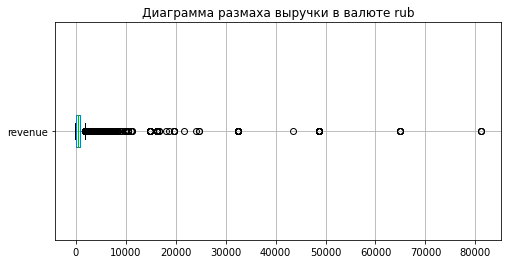

In [17]:
# диаграмма размаха
plt.figure(figsize=(8, 4))

orders_rub.boxplot(column='revenue', vert=False)

plt.title('Диаграмма размаха выручки в валюте rub')
plt.show()

Статистический анализ выявил аномальные значения в данных:

•  Минимальное значение: -90.76 рублей. Это некорректно и требует исправления.

•  Максимальное значение: 81174.54 рублей.

•  Медиана значительно отличается от среднего арифметического, что указывает на наличие выбросов, искажающих среднее.

•  Большое стандартное отклонение (871.52) в сочетании с относительно низким значением 3-го квартиля (791.7 рублей) подтверждает наличие выбросов.

•  Диаграмма размаха демонстрирует узкий "ящик" и множество точек-выбросов.

План действий:

Для очистки данных от выбросов, будет проведена корректировка. Значения будут ограничены следующими условиями:

•  Удаление отрицательных значений.
•  Ограничение сверху значением 99-го процентиля. Это позволит отфильтровать экстремальные значения, сохраняя при этом большую часть данных.

In [18]:
# находим 99-й процентиль и фильтруем данные 
proc99_rub = orders_rub['revenue'].quantile(0.99)
print('99-й процентиль составляет:', proc99_rub)

# фильтруем данные
orders_rub = orders_rub[(orders_rub['revenue'] >= 0) & (orders_rub['revenue'] < proc99_rub)]

99-й процентиль составляет: 2569.5942000000005


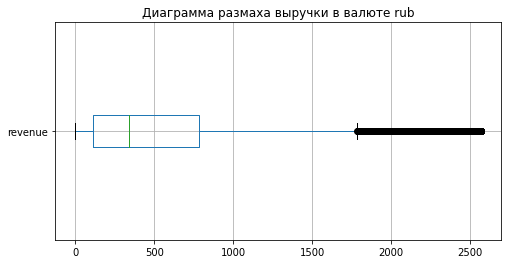

In [19]:
# новая диаграмма размаха
plt.figure(figsize=(8, 4))

orders_rub.boxplot(column='revenue', vert=False)

plt.title('Диаграмма размаха выручки в валюте rub')
plt.show()

В колонке `revenue` остались более адекватные значения выручки от заказов. Выбросы на новой диаграмме размаха вполне могут относиться к дорогим билетам, или же быть последствием большого количества билетов в одном заказе, поэтому не будем проводить их удаление.

Анализ по казахстанской валюте:

In [20]:
# общая статистическая информация
orders_kzt['revenue'].describe()

count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      26425.860000
Name: revenue, dtype: float64

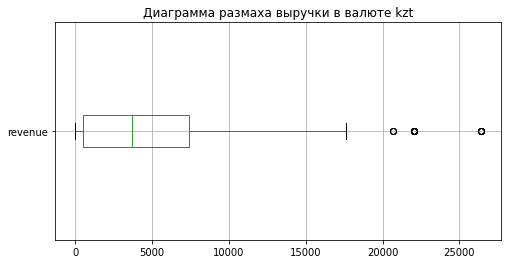

In [21]:
# диаграмма размаха
plt.figure(figsize=(8, 4))

orders_kzt.boxplot(column='revenue', vert=False)

plt.title('Диаграмма размаха выручки в валюте kzt')
plt.show()

Предварительный анализ показал следующие особенности в распределении данных:

•  Минимальное значение: 0 тенге.

•  Максимальное значение: 26425.86 тенге.

•  Медиана ниже среднего арифметического, что свидетельствует о наличии выбросов, смещающих среднее в сторону больших значений.

•  Визуализация данных с помощью диаграммы размаха подтверждает наличие выбросов.

Корректировка данных:

Для улучшения качества данных решено применить следующие фильтры:

•  Сохранить только неотрицательные значения.
•  Отфильтровать значения, превышающие 99-й процентиль. Этот подход позволит устранить наиболее экстремальные значения, не затрагивая основную часть распределения.

In [22]:
# находим 99-й процентиль и фильтруем данные 
proc99_kzt = orders_kzt['revenue'].quantile(0.99)
print('99-й процентиль составляет:', proc99_kzt)

# фильтруем данные
orders_kzt = orders_kzt[(orders_kzt['revenue'] >= 0) & (orders_kzt['revenue'] < proc99_kzt)]

99-й процентиль составляет: 17617.24


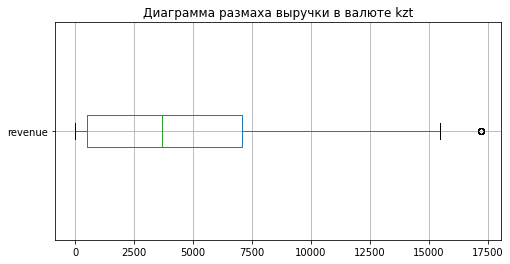

In [23]:
# новая диаграмма размаха
plt.figure(figsize=(8, 4))

orders_kzt.boxplot(column='revenue', vert=False)

plt.title('Диаграмма размаха выручки в валюте kzt')
plt.show()

В колонке `revenue` остались более адекватные значения выручки от заказов. Выбросы на новой диаграмме размаха вполне могут относиться к дорогим билетам, или же быть последствием большого количества билетов в одном заказе, поэтому не будем проводить их удаление.

Объединим два отфильтрованных по выручке датафрейма в один и проведем фильтрацию по индексам, затем сбросим их для нового корректного индексирования. С таким датафреймом удобнее работать далее, он подобен первоначальному датафрейму `orders_df`, но включает предобработку по выручке.

In [24]:
# объедияем датафреймы `orders_rub` и `orders_kzt`
orders_df = pd.concat([orders_rub, orders_kzt], axis=0)

# сортируем по индексу, сбрасываем его для назначения новых
orders_df.sort_index(inplace=True)
orders_df = orders_df.reset_index(drop=True)
orders_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


Перейдем к анализу количества билетов в заказе, представленных в столбце `tickets_count`.

In [25]:
# общая статистическая информация
orders_df['tickets_count'].describe()

count    287385.000000
mean          2.739858
std           1.162245
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          57.000000
Name: tickets_count, dtype: float64

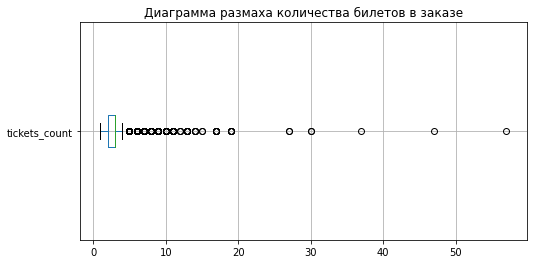

In [26]:
# диаграмма размаха
plt.figure(figsize=(8, 4))

orders_df.boxplot(column='tickets_count', vert=False)

plt.title('Диаграмма размаха количества билетов в заказе')
plt.show()

Статистический анализ показывает минимальное значение количества билетов - 1, максимальное - 57. Медиана близка к среднему значению. Диаграмма размаха показывает наличие выбросов. Для оптимальной очистки данных оставим записи ниже 99-го процентиля, так как маловероятно, что в данных содержится много заказов с высоким количеством билетов.

In [27]:
# находим 99-й процентиль и фильтруем данные 
proc99_tickets = orders_df['tickets_count'].quantile(0.99)
print('99-й процентиль составляет:', proc99_tickets)

# фильтруем данные
orders_df = orders_df[orders_df['tickets_count'] < proc99_tickets]

99-й процентиль составляет: 6.0


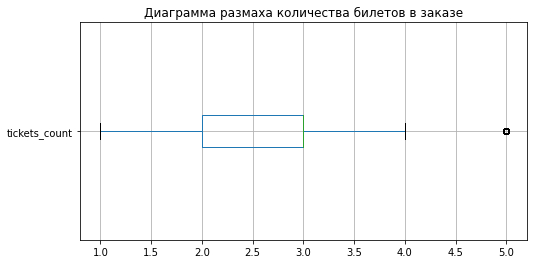

In [28]:
# новая диаграмма размаха
plt.figure(figsize=(8, 4))

orders_df.boxplot(column='tickets_count', vert=False)

plt.title('Диаграмма размаха количества билетов в заказе')
plt.show()

В колонке `tickets_count` остались более вероятные значения количества билетов в заказах.

### Проверка явных и неявных дубликатов

Перед проверкой на дубликаты объединим датафреймы по полю `event_id` в один общий датафрейм `total_df`:

In [29]:
# объединение датафреймов
total_df = orders_df.merge(events_df, on='event_id', how='left')
total_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4"
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6"
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8"
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8"


Ищем явные дубликаты:

In [30]:
# проверка явных дубликатов
total_df.duplicated().sum()

0

Обратим внимание на проверку неявных дубликатов - записей без учета идентификатора заказа - если такие дубликаты имеются, скорее всего произошла ошибка в системе и запись о заказе внеслась, как минимум, дважды, поэтому подобные дубликаты можно удалить из датафрейма. Маловероятно, что в конкретную секунду пользователь мог оформить сразу несколько заказов (так как поле `created_ts_msk` включено в проверку на дубликаты).

In [31]:
# проверка неявных дубликатов
cols = total_df.columns    # без order_id
total_df.duplicated(subset=cols[1:].to_list()).sum()

30

In [32]:
# удаление неявных дубликатов
total_df = total_df.drop_duplicates(subset=cols[1:])

Осуществим еще одну проверку на неявные дубликаты по столбцам `user_id`, `created_ts_msk`, `event_id`, `device_type_canonical`, `revenue`, `tickets_count`. Если такие записи будут найдены - это означает, что конкретный пользователь единовременно (до секунды) совершил несколько заказов на одно и то же мероприятие с одного и того же устройства с одним и тем же количеством билетов, что в принципе невозможно, если только это не ошибка системы:

In [33]:
# проверка явных дубликатов
cols = ['user_id', 'created_ts_msk', 'event_id', 'device_type_canonical', 'revenue', 'tickets_count']
total_df.duplicated(subset=cols).sum()

8

Удалим найденные дубликаты:

In [34]:
# удаление неявных дубликатов
total_df = total_df.drop_duplicates(subset=cols).reset_index(drop=True)

### Преобразование типов данных

Как было отмечено на моменте знакомства с данными, следует изменить тип данных у колонок `created_dt_msk` и `created_ts_msk` на тип даты и времени. Это также касается и колонки `data` датафрейма `tenge_df`:

In [39]:
# изменение типа данных у столбцов
total_df['created_dt_msk'] = pd.to_datetime(total_df['created_dt_msk'])
total_df['created_ts_msk'] = pd.to_datetime(total_df['created_ts_msk'])
tenge_df['data'] = pd.to_datetime(tenge_df['data'])

In [40]:
# понижение размерности
cols = ['revenue', 'total', 'days_since_prev']
for col in cols:
    total_df[col] = pd.to_numeric(total_df[col], downcast='float')

total_df['tickets_count'] = pd.to_numeric(total_df['tickets_count'], downcast='integer')

In [41]:
total_df[['revenue', 'tickets_count', 'total', 'days_since_prev']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283262 entries, 0 to 283261
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   revenue          283262 non-null  float32
 1   tickets_count    283262 non-null  int8   
 2   total            283262 non-null  float32
 3   days_since_prev  261894 non-null  float32
dtypes: float32(3), int8(1)
memory usage: 3.5 MB


### Создание новых столбцов

Перед переводом выручки в одну валюту, оставим в датафрейме `tenge_df` данные только за рассматриваемый период заказов.

In [42]:
# получение границ периода
min_data = total_df['created_dt_msk'].min()
max_data = total_df['created_dt_msk'].max()
print('Границы рассматриваемого периода:', min_data, '-', max_data)

Границы рассматриваемого периода: 2024-06-01 00:00:00 - 2024-10-31 00:00:00


In [43]:
# фильтруем датафрейм tenge_df
tenge_df = tenge_df[(tenge_df['data'] >= min_data) & (tenge_df['data'] <= max_data)]
tenge_df.head()

,data,nominal,curs,cdx
143,2024-06-01,100,20.2773,kzt
144,2024-06-02,100,20.2773,kzt
145,2024-06-03,100,20.2773,kzt
146,2024-06-04,100,19.9833,kzt
147,2024-06-05,100,19.8527,kzt


Осуществим добавление новой колонки:

In [44]:
# добавляем данные о курсе валют
total_df = pd.merge(total_df, tenge_df, left_on = 'created_dt_msk', right_on = 'data', how='left')

In [45]:
# работа с новым столбцом
total_df['revenue_rub'] = total_df['revenue']

# перевод тенге в рубли
mask = total_df['currency_code'] == 'kzt'
total_df.loc[mask, 'revenue_rub'] = (total_df.loc[mask, 'revenue'] * (total_df.loc[mask, 'curs'] / total_df.loc[mask, 'nominal'])).astype(np.float32)

# удаляем справочные колонки из общего датафрейма
total_df = total_df.drop(columns=['data', 'nominal', 'curs', 'cdx'])

Рассчитаем выручку с одного билета в российской валюте, опираясь на ранее созданый столбец `revenue_rub` и количество билетов `tickets_count`:

In [46]:
# создание столбца one_ticket_revenue_rub
total_df['one_ticket_revenue_rub'] = total_df['revenue_rub'] / total_df['tickets_count']

Выделим месяц оформления заказа в отдельный столбец `month`:

In [47]:
# создание столбца month
total_df['month'] = total_df['created_dt_msk'].dt.month

Создадим столбец с информацией о сезонности `season`:

In [53]:
# функция, определяющая сезон по номеру месяца
def define_season(row):
    if row['month'] in (12, 1, 2):
        return 'зима'
    elif row['month'] in (3, 4, 5):
        return 'весна'
    elif row['month'] in (6, 7, 8):
        return 'лето'
    else:
        return 'осень'

In [54]:
# создание столбца season через функцию
total_df['season'] = ''
total_df['season'] = total_df.apply(define_season, axis=1)

После создания новых полей посмотрим на полученный результат:

In [55]:
# просмотр результата
total_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.939941,...,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",1521.939941,380.484985,8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.450012,...,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",289.450012,144.725006,7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.569946,...,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",1258.569946,314.642487,10,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.490000,...,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",8.490000,4.245000,7,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.410034,...,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",1390.410034,463.470001,10,осень


Определим, сколько данных было отобрано после фильтрации с опорой на размерность датафрейма. Так как объединенный датафрейм включал присоединение к датафрейму `orders_df`, значит сравнивать изменение объема следует по нему:

In [56]:
print('Размерность до предобработки:', orders_shape)
print('Размерность после предобработки (включая объединение):', total_df.shape)

print('Отфильтрованных строк:', orders_shape[0] - total_df.shape[0])
print('В процентном соотношении данных отфильтровано:', round((orders_shape[0] - total_df.shape[0]) / orders_shape[0] * 100, 2), '%')

Размерность до предобработки: (290849, 14)
Размерность после предобработки (включая объединение): (283262, 28)
Отфильтрованных строк: 7587
В процентном соотношении данных отфильтровано: 2.61 %


**Промежуточный вывод:**
1. **Проверка на пропуски.** В датафрейме `orders_df` пропуски содержатся только в колонке `days_since_prev` в виду специфики данных, в остальных столбцах пропусков нет. В датафреймах `events_df` и `tenge_df` пропусков не наблюдается. Таким образом, выгрузка из SQL прошла успешно.
2. **Изучение значений в ключевых столбцах.** Для категорильных столбцов в данных не выявлено ошибок. Для количественных данных проведена фильтрация по 99-му процентилю как для столбца `revenue` с выручкой в разрезе каждой валюты, так и для столбца `tickets_count` с количеством билетов в заказе.
3. **Явные и неявные дубликаты.** Перед проверкой на дубликаты осуществлено объединение датафреймов `orders_df` и `events_df`. Явных дубликатов в данных не обнаружено. Неявные дубликаты в количестве 38 штук удалены из объединенного датафрейма в виду предположения об ошибке записи со стороны системы.
4. **Преобразование типов данных.** Проведено изменение типов данных у столбцов `created_dt_msk` и `created_ts_msk` объединенного датафрейма, а также столбца `data` датафрейма `tenge_df`. У колонок объединенного датафрейма с количественными данными по возможности проведено понижение размерности.
5. **Создание новых столбцов.** На этом этапе созданы новые столбцы: `revenue_rub`, в котором выручка представлена в российской валюте, `one_ticket_revenue_rub`с выручкой с продажи одного билета, `month` с выделенным месяцем совершения заказа, `season` с информацией о сезонности.

## Исследовательский анализ данных

### Анализ распределения заказов по сегментам и их сезонные изменения

1. Для каждого месяца найдем количество заказов и визуализируем результаты.

In [57]:
# количество заказов в разрезе каждого месяца
orders_per_month = total_df.groupby('month').agg({'order_id': 'count'})
orders_per_month

,order_id
month,
6,33655
7,39820
8,43906
9,68264
10,97617


<Figure size 720x576 with 0 Axes>

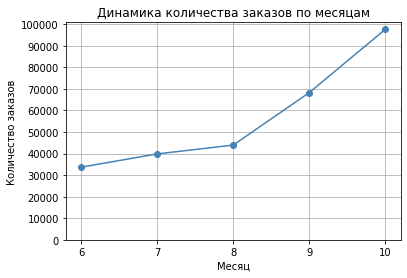

In [58]:
# визуализация
plt.figure(figsize=(10, 8))

orders_per_month.plot(
    kind='line',
    marker='o',
    color='steelblue',
    legend=False
)

plt.title('Динамика количества заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')

plt.xticks(np.arange(6, 11, 1))
plt.yticks(np.arange(0, 110000, 10000))
plt.grid()
plt.show()

2. Для осеннего и летнего периодов сравним распределение заказов билетов по разным категориям.

* по типу мероприятия (`event_type_main`):

In [59]:
# агрегируем по заданной категории
category1_df = total_df.groupby(['event_type_main', 'season'])['order_id'].count().unstack() / total_df.groupby('season')['order_id'].count()
category1_df

season,лето,осень
event_type_main,,
выставки,0.020378,0.014408
другое,0.268800,0.195375
концерты,0.427241,0.374558
спорт,0.024876,0.110694
стендап,0.052998,0.040963
театр,0.201591,0.254038
ёлки,0.002283,0.009832


<Figure size 720x576 with 0 Axes>

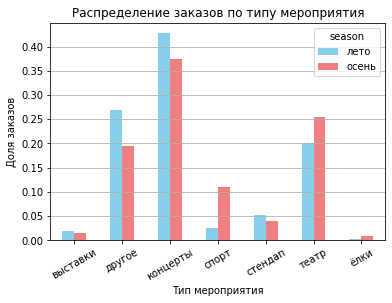

In [70]:
plt.figure(figsize=(10, 8))

category1_df.plot(
    kind='bar',
    rot=30,
    color=['skyblue', 'lightcoral'], 
)

plt.title('Распределение заказов по типу мероприятия')
plt.xlabel('Тип мероприятия')
plt.ylabel('Доля заказов')

plt.grid(axis='y')
plt.show()

* по типу устройства `device_type_canonical`:

In [62]:
# агрегируем по заданной категории
category2_df = total_df.groupby(['device_type_canonical', 'season'])['order_id'].count().unstack() / total_df.groupby('season')['order_id'].count()
category2_df

season,лето,осень
device_type_canonical,,
desktop,0.193225,0.20273
mobile,0.806775,0.79727


<Figure size 720x576 with 0 Axes>

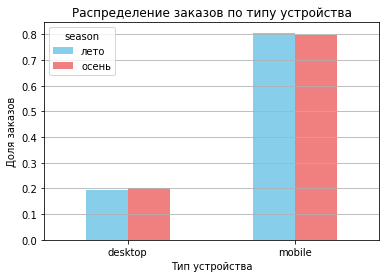

In [63]:
# визуализация
plt.figure(figsize=(10, 8))

category2_df.plot(
    kind='bar',
    rot=0,
    color=['skyblue', 'lightcoral'],
)

plt.title('Распределение заказов по типу устройства')
plt.xlabel('Тип устройства')
plt.ylabel('Доля заказов')

plt.grid(axis='y')
plt.show()

* по возрастному рейтингу `age_limit`:

In [64]:
# агрегируем по заданной категории
category3_df = total_df.groupby(['age_limit', 'season'])['order_id'].count().unstack() / total_df.groupby('season')['order_id'].count()
category3_df

season,лето,осень
age_limit,,
0,0.176690,0.233637
6,0.182321,0.176006
12,0.204914,0.221605
16,0.285992,0.264865
18,0.150084,0.103888


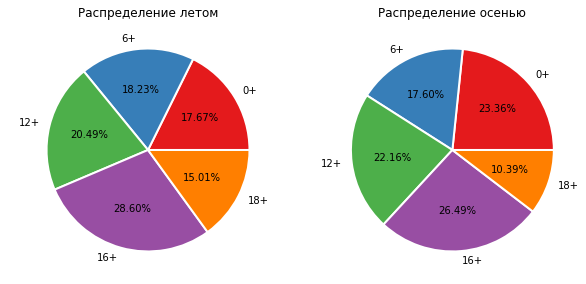

In [67]:
# визуализация 
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
category3_df['лето'].plot(
    kind='pie',
    y='лето',
    autopct='%1.2f%%',
    colors=sns.color_palette('Set1'),
    labels=['0+', '6+', '12+', '16+', '18+'],
    wedgeprops={'linewidth': 2, 'edgecolor': 'white'}
)
plt.title('Распределение летом')
plt.ylabel(' ')

plt.subplot(1, 2, 2)
category3_df['осень'].plot(
    kind='pie',
    y='осень',
    autopct='%1.2f%%',
    colors=sns.color_palette('Set1'),
    labels=['0+', '6+', '12+', '16+', '18+'],
    wedgeprops={'linewidth': 2, 'edgecolor': 'white'}
)
plt.title('Распределение осенью')
plt.ylabel(' ')

plt.show()

3. Изучение изменения выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью.

In [68]:
avg_revenue_per_type = total_df.groupby(['event_type_main', 'season'])['one_ticket_revenue_rub'].mean().unstack()
avg_revenue_per_type

season,лето,осень
event_type_main,,
выставки,86.722321,91.977829
другое,77.489540,75.936325
концерты,303.186859,268.354004
спорт,51.018520,50.081200
стендап,219.366180,231.809494
театр,214.748596,176.496216
ёлки,273.779510,232.569397


In [69]:
avg_revenue_per_type['diff_%'] = (avg_revenue_per_type['осень'] - avg_revenue_per_type['лето']) / avg_revenue_per_type['лето'] * 100
avg_revenue_per_type

season,лето,осень,diff_%
event_type_main,,,
выставки,86.722321,91.977829,6.060157
другое,77.489540,75.936325,-2.004419
концерты,303.186859,268.354004,-11.488906
спорт,51.018520,50.081200,-1.837216
стендап,219.366180,231.809494,5.672394
театр,214.748596,176.496216,-17.812634
ёлки,273.779510,232.569397,-15.052300


<Figure size 720x576 with 0 Axes>

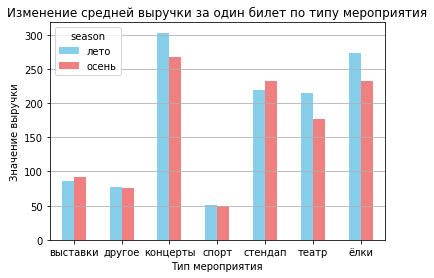

In [71]:
# визуализация
plt.figure(figsize=(10, 8))

avg_revenue_per_type[['лето', 'осень']].plot(
    kind='bar',
    rot=0,
    color=['skyblue', 'lightcoral'],
)

plt.title('Изменение средней выручки за один билет по типу мероприятия')
plt.xlabel('Тип мероприятия')
plt.ylabel('Значение выручки')

plt.grid(axis='y')
plt.show()

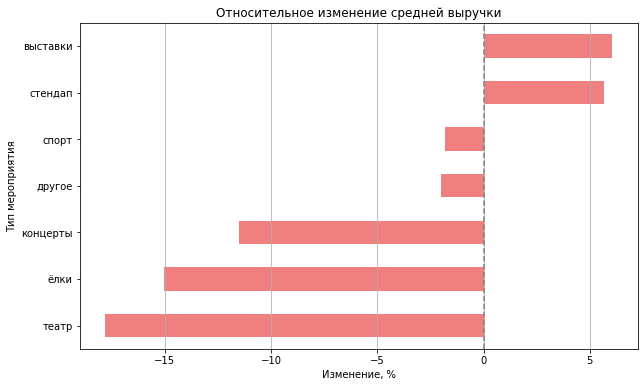

In [73]:
# Сортируем по убыванию/возрастанию для наглядности
avg_revenue_per_type_sorted = avg_revenue_per_type.sort_values('diff_%')

# Визуализация
plt.figure(figsize=(10, 6))
avg_revenue_per_type_sorted['diff_%'].plot(
    kind='barh',
    color='lightcoral'
)

plt.title('Относительное изменение средней выручки')
plt.xlabel('Изменение, %')
plt.ylabel('Тип мероприятия')
plt.axvline(x=0, color='gray', linestyle='--')  # вертикальная линия на 0
plt.grid(axis='x')
plt.show()

**Промежуточный вывод:**
1. **Количество заказов для каждого месяца.** По визуализации видно, что фиксируется увеличение количества заказов к концу октября 2024 года практически в 3 раза от начала рассматриваемого периода.
2. **Распределение заказов билетов по категориям для осеннего и летнего периодов.**
    * По типу мероприятия `event_type_main`: сравнение между сезонами показывает снижение доли заказов на концерты, стендапы, выставки и "другое" осенью, но одновременно демонстрирует рост на типы мероприятий "спорт", "театр" и даже "елки".
    * По типу устройства `device_type_canonical`: сравнение между сезонами показывает незначительное повышение доли заказов, сделанных с компьютера, и незначительное снижение доли заказов, сделанных с телефона, в осенний период.
    * По возрастному рейтингу `age_limit`: и летом и осенью абсолютный лидер - мероприятия с рейтингом 16+; второе место летом занимают мероприятия 12+, осенью - мероприятия 0+; третье место - мероприятия 6+ летом и 12+ осенью; наименьшая доля мероприятий в двух сезонах одновременно - мероприятия 18+, хотя соответствующая доля осенью значительно меньше летней.
3. **Изучение изменения выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью.** Можно сделать вывод, что средняя выручка за один билет осенью растет (на 5.25 рублей в среднем) у выставок (хотя доля заказов, как было замечено ранее, на них падает), и у стендапов (в среднем на 12.4 рубля). На все остальные типы мероприятий средняя выручка за один билет снижается по сравнению с летним периодом, причем наиболее заметна разница у концертов, елок и театров.

### Осенняя активность пользователей

Изучим активность пользователей осенью 2024 года. Для этого отфильтруем датафрейм `total_df` либо по дате `created_dt_msk`, либо по сезону `season`. Назовем получившийся датафрейм `autumn_df`. 

In [74]:
# фильтр на осень
autumn_df = total_df[total_df['season'] == 'осень'].reset_index(drop=True)
autumn_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,revenue_rub,one_ticket_revenue_rub,month,season
0,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.569946,...,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",1258.569946,314.642487,10,осень
1,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.410034,...,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",1390.410034,463.470001,10,осень
2,2613713,000898990054619,2024-10-23,2024-10-23 15:12:00,500862,нет,12,rub,mobile,902.739990,...,Лугоградская область,Кристалевск,193.0,930.0,"Школа живописи ""Солнце"" Групп","бул. Отрадный, д. 4 стр. 1",902.739990,300.913330,10,осень
3,4657981,000a55a418c128c,2024-09-29,2024-09-29 19:39:12,265857,нет,12,rub,mobile,47.779999,...,Поленовский край,Дальнозолотск,18.0,3159.0,"Клуб начинающих писателей ""Таблицы"" Групп","ул. О.Кошевого, д. 7",47.779999,47.779999,9,осень
4,4657952,000a55a418c128c,2024-10-15,2024-10-15 10:29:04,271579,нет,12,rub,mobile,74.839996,...,Поленовский край,Дальнозолотск,18.0,3159.0,"Клуб начинающих писателей ""Таблицы"" Групп","ул. О.Кошевого, д. 7",74.839996,37.419998,10,осень


1. Проанализируем динамику изменений по дням для:
  - общего числа заказов;
  - количества активных пользователей DAU;
  - среднего числа заказов на одного пользователя;
  - средней стоимости одного билета.

Будем использовать сводную таблицу `pvt_table` для удобного хранения в одном массиве данных:

In [75]:
# строим сводную таблицу
pvt_table = pd.pivot_table(
    autumn_df,
    values=['order_id', 'user_id', 'one_ticket_revenue_rub'],
    index=['created_dt_msk'],
    aggfunc={'order_id': 'count', 'user_id': 'nunique', 'one_ticket_revenue_rub': 'mean'}
)
pvt_table['avg_orders_per_user'] = pvt_table['order_id'] / pvt_table['user_id']
pvt_table.columns = ['avg_one_ticket', 'orders_cnt', 'users_cnt', 'avg_orders_per_user']
pvt_table

,avg_one_ticket,orders_cnt,users_cnt,avg_orders_per_user
created_dt_msk,,,,
2024-09-01,200.713425,1302,559,2.329159
2024-09-02,190.418274,1363,569,2.395431
2024-09-03,81.148308,4972,769,6.465540
2024-09-04,179.551559,1737,675,2.573333
2024-09-05,190.276260,1921,732,2.624317
...,...,...,...,...
2024-10-27,187.701752,2814,1023,2.750733
2024-10-28,171.745178,2796,975,2.867692
2024-10-29,178.756927,2795,994,2.811871


Визуализируем каждую метрику в динамике по дням:

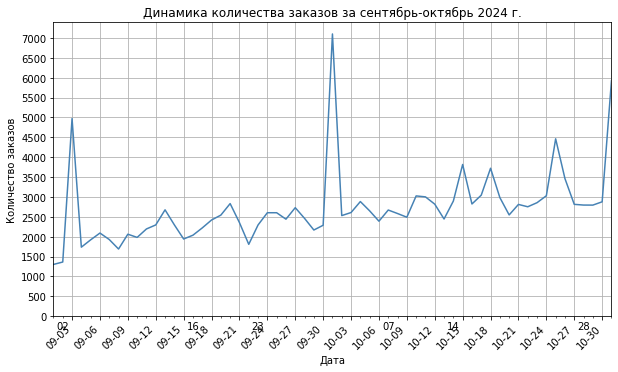

In [76]:
# визуализация заказов
plt.figure(figsize=(10, 6))

pvt_table['orders_cnt'].plot(
    kind='line',
    color='steelblue')

plt.title('Динамика количества заказов за сентябрь-октябрь 2024 г.')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gcf().autofmt_xdate()
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 7500, 500))
plt.grid()
plt.show()

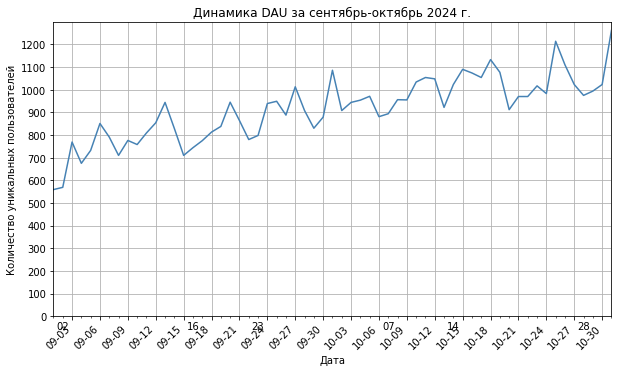

In [77]:
# визуализация уникальных пользователей
plt.figure(figsize=(10, 6))

pvt_table['users_cnt'].plot(
    kind='line',
    color='steelblue')

plt.title('Динамика DAU за сентябрь-октябрь 2024 г.')
plt.xlabel('Дата')
plt.ylabel('Количество уникальных пользователей')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gcf().autofmt_xdate()
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 1300, 100))
plt.grid()
plt.show()

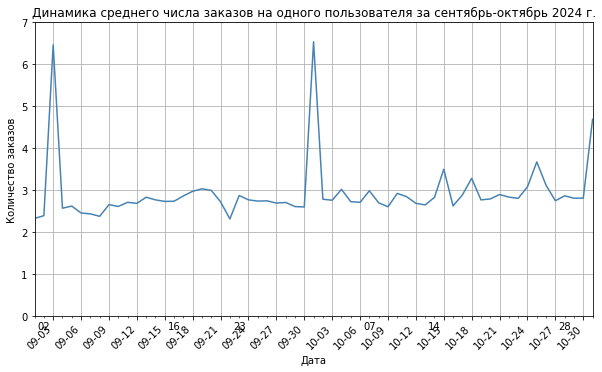

In [78]:
# визуализация среднего числа заказов
plt.figure(figsize=(10, 6))

pvt_table['avg_orders_per_user'].plot(
    kind='line',
    color='steelblue')

plt.title('Динамика среднего числа заказов на одного пользователя за сентябрь-октябрь 2024 г.')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gcf().autofmt_xdate()
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 8, 1))
plt.grid()
plt.show()

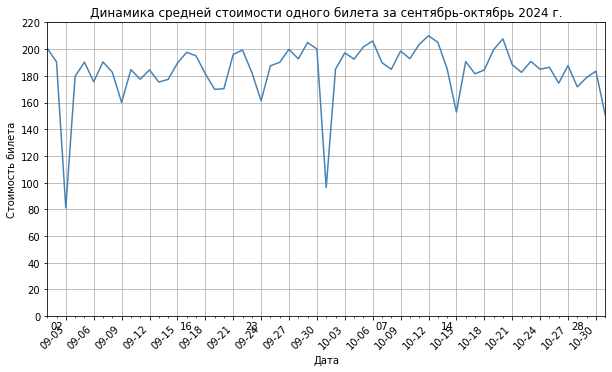

In [79]:
# визуализация средней стоимости одного билета
plt.figure(figsize=(10, 6))

pvt_table['avg_one_ticket'].plot(
    kind='line',
    color='steelblue')

plt.title('Динамика средней стоимости одного билета за сентябрь-октябрь 2024 г.')
plt.xlabel('Дата')
plt.ylabel('Стоимость билета')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gcf().autofmt_xdate()
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 230, 20))
plt.grid()
plt.show()

2. Изучим недельную цикличность.

Для изучения недельной цикличности выделим день недели и сравним пользовательскую активность в будни и выходные:

In [80]:
# выделение дня недели
autumn_df['day_of_week'] = autumn_df['created_dt_msk'].dt.dayofweek
autumn_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,city_name,city_id,venue_id,venue_name,venue_address,revenue_rub,one_ticket_revenue_rub,month,season,day_of_week
0,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.569946,...,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",1258.569946,314.642487,10,осень,6
1,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.410034,...,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",1390.410034,463.470001,10,осень,4
2,2613713,000898990054619,2024-10-23,2024-10-23 15:12:00,500862,нет,12,rub,mobile,902.739990,...,Кристалевск,193.0,930.0,"Школа живописи ""Солнце"" Групп","бул. Отрадный, д. 4 стр. 1",902.739990,300.913330,10,осень,2
3,4657981,000a55a418c128c,2024-09-29,2024-09-29 19:39:12,265857,нет,12,rub,mobile,47.779999,...,Дальнозолотск,18.0,3159.0,"Клуб начинающих писателей ""Таблицы"" Групп","ул. О.Кошевого, д. 7",47.779999,47.779999,9,осень,6
4,4657952,000a55a418c128c,2024-10-15,2024-10-15 10:29:04,271579,нет,12,rub,mobile,74.839996,...,Дальнозолотск,18.0,3159.0,"Клуб начинающих писателей ""Таблицы"" Групп","ул. О.Кошевого, д. 7",74.839996,37.419998,10,осень,1


In [81]:
# функция, определяющая будний/выходной день
# [0, 1, 2, 3, 4] - будние дни
# [5, 6] - выходные дни
def define_day(row):
    if row['day_of_week'] in (0, 1, 2, 3, 4):
        return 'будний'
    else:
        return 'выходной'

In [82]:
# применение функции
autumn_df['day_type'] = autumn_df.apply(define_day, axis=1)

Построим новую сводную таблицу `pvt_table_dow`:

In [83]:
# строим сводную таблицу
pvt_table_dow = pd.pivot_table(
    autumn_df,
    values=['order_id', 'user_id', 'one_ticket_revenue_rub'],
    index=['day_type'],
    aggfunc={'order_id': 'count', 'user_id': 'nunique', 'one_ticket_revenue_rub': 'mean'}
)
pvt_table_dow['avg_orders_per_user'] = pvt_table_dow['order_id'] / pvt_table_dow['user_id']
pvt_table_dow.columns = ['avg_one_ticket', 'orders_cnt', 'users_cnt', 'avg_orders_per_user']
pvt_table_dow

,avg_one_ticket,orders_cnt,users_cnt,avg_orders_per_user
day_type,,,,
будний,173.546509,125816,13125,9.585981
выходной,195.463104,40065,7101,5.642163


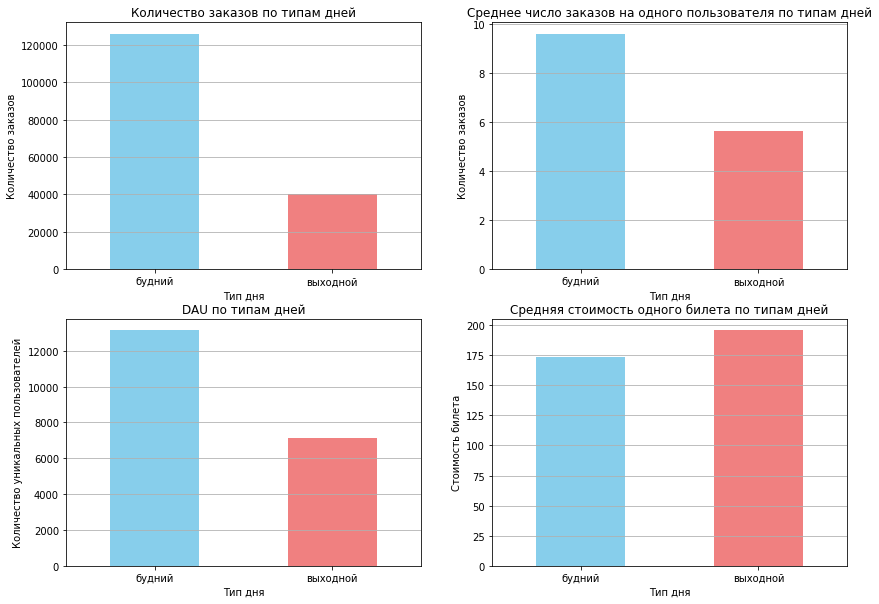

In [86]:
# визуализации
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
pvt_table_dow['orders_cnt'].plot(
    kind='bar', 
    rot=0,
    color=['skyblue', 'lightcoral'],
    title='Количество заказов по типам дней'
)
plt.xlabel('Тип дня')
plt.ylabel('Количество заказов')
plt.grid(axis='y')

plt.subplot(2, 2, 2)
pvt_table_dow['avg_orders_per_user'].plot(
    kind='bar', 
    rot=0,
    color=['skyblue', 'lightcoral'],
    title='Среднее число заказов на одного пользователя по типам дней'
)
plt.xlabel('Тип дня')
plt.ylabel('Количество заказов')
plt.grid(axis='y')

plt.subplot(2, 2, 3)
pvt_table_dow['users_cnt'].plot(
    kind='bar', 
    rot=0,
    color=['skyblue', 'lightcoral'],
    title='DAU по типам дней'
)
plt.xlabel('Тип дня')
plt.ylabel('Количество уникальных пользователей')
plt.grid(axis='y')

plt.subplot(2, 2, 4)
pvt_table_dow['avg_one_ticket'].plot(
    kind='bar', 
    rot=0,
    color=['skyblue', 'lightcoral'],
    title='Средняя стоимость одного билета по типам дней'
)
plt.xlabel('Тип дня')
plt.ylabel('Стоимость билета')
plt.grid(axis='y')

**Промежуточный вывод:** 
* Динамика изменений по дням за первые месяцы осени показывает рост как количества заказов (с заметными пиками 03.09, 01.10 и 31.10), так и количества уникальных пользователей. Среднее число заказов на одного пользователя остается относительно стабильным и лежит в промежутке 2-4 с некоторыми пиками 03.09, 01.10 и 31.10. Средняя стоимость одного билета также остается стабильной (кроме минимумов 03.09, 01.10 и 15.10), но к концу рассматриваемого периода видна тенденция к снижению.
* По недельной цикличности можно заметить, что в выходные количество заказов, уникальных пользователей и среднее число заказов на одного пользователя меньше, если сравнивать с будними днями. Одновременно в выходные средняя стоимость одного билета выше, чем в будний день.

### Популярные события и партнеры

Посмотрим, как события распределены по регионам и партнёрам. Это позволит выделить ключевые регионы и партнёров, которые вносят наибольший вклад в выручку.

* Для каждого региона посчитаем уникальное количество мероприятий и общее число заказов. 

In [87]:
# агрегируем данные по регионам
regions_df = autumn_df.groupby('region_name').agg({'event_id': 'nunique', 'order_id': 'count'})

In [88]:
# сортировка по уникальным мероприятиям
regions_df.sort_values(by='event_id', ascending=False).head()

,event_id,order_id
region_name,,
Каменевский регион,3895,45952
Североярская область,2594,20327
Широковская область,792,8531
Светополянский округ,759,4716
Речиновская область,527,3512


In [89]:
# сортировка по количеству заказов
regions_df.sort_values(by='order_id', ascending=False).head()

,event_id,order_id
region_name,,
Каменевский регион,3895,45952
Североярская область,2594,20327
Медовская область,368,11764
Широковская область,792,8531
Озернинский край,293,7398


In [90]:
# перевод в доли
regions_df['part_events'] = regions_df['event_id'] / regions_df['event_id'].sum()    # общее количество мероприятий во всех регионах
regions_df['part_orders'] = regions_df['order_id'] / regions_df['order_id'].sum()    # общее количество заказов во всех регионах

In [91]:
# сортировка по доле мероприятий
regions_df.sort_values(by='part_events', ascending=False).head()

,event_id,order_id,part_events,part_orders
region_name,,,,
Каменевский регион,3895,45952,0.247145,0.277055
Североярская область,2594,20327,0.164594,0.122556
Широковская область,792,8531,0.050254,0.051435
Светополянский округ,759,4716,0.048160,0.028434
Речиновская область,527,3512,0.033439,0.021175


In [92]:
# сортировка по доле заказов
regions_df.sort_values(by='part_orders', ascending=False).head()

,event_id,order_id,part_events,part_orders
region_name,,,,
Каменевский регион,3895,45952,0.247145,0.277055
Североярская область,2594,20327,0.164594,0.122556
Медовская область,368,11764,0.023350,0.070928
Широковская область,792,8531,0.050254,0.051435
Озернинский край,293,7398,0.018591,0.044604


* Для каждого билетного партнера посчитаем общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов.

In [93]:
# агрегируем данные по билетным партнерам
partners_df = autumn_df.groupby('service_name').agg({'event_id': 'nunique', 'order_id': 'count', 'revenue': 'sum'})

In [94]:
# сортировка по уникальным мероприятиям
np.round(partners_df.sort_values(by='event_id', ascending=False).head())

,event_id,order_id,revenue
service_name,,,
Лови билет!,3594,25378,10100622.0
Билеты без проблем,2819,31746,13148087.0
Билеты в руки,2448,25178,7368728.0
Облачко,1401,15342,10427507.0
Лучшие билеты,1384,12263,1621042.0


In [95]:
# сортировка по количеству заказов
partners_df.sort_values(by='order_id', ascending=False).head()

,event_id,order_id,revenue
service_name,,,
Билеты без проблем,2819,31746,13148087.0
Лови билет!,3594,25378,10100622.0
Билеты в руки,2448,25178,7368728.0
Мой билет,998,19169,11272275.0
Облачко,1401,15342,10427507.0


In [96]:
# сортировка по выручке
partners_df.sort_values(by='revenue', ascending=False).head()

,event_id,order_id,revenue
service_name,,,
Билеты без проблем,2819,31746,13148087.0
Мой билет,998,19169,11272275.0
Облачко,1401,15342,10427507.0
Лови билет!,3594,25378,10100622.0
Весь в билетах,596,9290,9121520.0


Дополнительно добавим столбец с долей обработанных заказов у конкретного партнера от общего числа заказов:

In [97]:
# перевод в доли
partners_df['part_orders'] = partners_df['order_id'] / partners_df['order_id'].sum() 
partners_df['part_revenue'] = partners_df['revenue'] / partners_df['revenue'].sum()

In [98]:
# сортировка по доле заказов
partners_df.sort_values(by='part_orders', ascending=False).head()

,event_id,order_id,revenue,part_orders,part_revenue
service_name,,,,,
Билеты без проблем,2819,31746,13148087.0,0.191378,0.160648
Лови билет!,3594,25378,10100622.0,0.152989,0.123413
Билеты в руки,2448,25178,7368728.0,0.151784,0.090034
Мой билет,998,19169,11272275.0,0.115559,0.137729
Облачко,1401,15342,10427507.0,0.092488,0.127407


In [99]:
# сортировка по доле выручки
partners_df.sort_values(by='part_revenue', ascending=False).head()

,event_id,order_id,revenue,part_orders,part_revenue
service_name,,,,,
Билеты без проблем,2819,31746,13148087.0,0.191378,0.160648
Мой билет,998,19169,11272275.0,0.115559,0.137729
Облачко,1401,15342,10427507.0,0.092488,0.127407
Лови билет!,3594,25378,10100622.0,0.152989,0.123413
Весь в билетах,596,9290,9121520.0,0.056004,0.111450


**Промежуточный вывод:**
1. Среди регионов в абсолютных значениях как по разнообразию мероприятий, так и по количеству заказов выделяются Каменевский регион, Североярская область и Широковская область. Также в лидерах по разнообразию мероприятий состоит Светополянский округ, а в лидерах по большому количеству заказов - Медовская область. Долевая часть `part_events`, то есть доля проводимых в конкретном регионе мероприятий от их общего количества вообще, подтверждает наличие уже обозначенных лидеров.
2. Среди билетных партнеров в абсолютных значениях выделяются "Лови билет!", "Билеты без проблем" и "Билеты в руки" - у них наибольшее количество уникальных мероприятий, а также количество обработанных заказов. Такая же ситуация и при переходе к доле обработанных заказов от общего количества возможных заказов. По выручке выделяются уже упомянутые сервис "Билеты без проблем" и "Лови билет!", а также "Мой билет" и "Облачко".

## Статистический анализ данных

Проверим несколько гипотез относительно активности пользователей мобильных и стационарных устройств. Обе гипотезы предполагают большую активность пользователей мобильных устройств. Используем данные только за осенний период.

### Гипотеза 1

**Формулировка:** среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

**H0:** среднее количество заказов на одного пользователя  у мобильного приложения не выше,

**H1:** среднее количество заказов на одного пользователя выше у мобильного приложения.

In [100]:
# проведем агрегацию данных
test1_df = autumn_df.groupby(['user_id', 'device_type_canonical'])['order_id'].nunique().unstack()
test1_df.head()

device_type_canonical,desktop,mobile
user_id,,
0005ca5e93f2cf4,NaN,1.0
000898990054619,NaN,2.0
000a55a418c128c,NaN,2.0
001e7037d013f0f,NaN,2.0
00245c702bc343e,NaN,2.0


In [101]:
# изучаем выборки по отдельности
print('Статистическая информация по мобильным заказам')
display(test1_df['mobile'].dropna().describe())   # исключим пропуски

print('\nСтатистическая информация по десктопным заказам')
display(test1_df['desktop'].dropna().describe())    # исключим пропуски

Статистическая информация по мобильным заказам


count    14089.000000
mean         9.386898
std         67.218494
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       4257.000000
Name: mobile, dtype: float64


Статистическая информация по десктопным заказам


count    4827.000000
mean        6.966853
std        35.316615
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max      1458.000000
Name: desktop, dtype: float64

Приходим к выводу, что в выборках количества заказов пользователей по обоим типам устройств есть выбросы, о чем говорит как большое максимальное значение в каждой выборке, так и значительное смещение среднего значения в большую сторону, если сравнивать с медианой. 

**Подходящий тест:** тест Манна-Уитни (U-критерий). Этот непараметрический тест сравнивает средние тенденции между выборками, ориентируясь лишь на характер распределения, у него нет требований и он устойчив к выбросам из-за рангового преобразования.

In [102]:
# проверка первой гипотезы
test1_mobile = test1_df['mobile'].dropna().to_list()
test1_desktop = test1_df['desktop'].dropna().to_list()

# уровень значимости
alpha = 0.05
stat_mw, p_value = st.mannwhitneyu(test1_mobile, test1_desktop, alternative='greater')

if p_value >= alpha:
    print(f"Гипотеза H0 находит подтверждение: {p_value} >= {alpha}. \
        \n--> Cреднее количество заказов на одного пользователя одинаково у обоих типов устройств.")
else:
    print(f"Имеет место отклонение гипотезы H0: {p_value} < {alpha}. \
        \n--> Среднее количество заказов на одного пользователя выше у мобильных устройств, чем у пользователей десктопов.")

Имеет место отклонение гипотезы H0: 1.1556787312496519e-07 < 0.05.         
--> Среднее количество заказов на одного пользователя выше у мобильных устройств, чем у пользователей десктопов.


### Гипотеза 2

**Формулировка:** среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

**H0:** среднее время между заказами не отличаются по типу используемого устройства,

**H1:** среднее время между заказами выше у мобильного приложения.

In [103]:
# соберем выборки
test2_mobile = autumn_df[autumn_df['device_type_canonical'] == 'mobile']['days_since_prev'].dropna()   # исключаем пропуски
test2_desktop = autumn_df[autumn_df['device_type_canonical'] == 'desktop']['days_since_prev'].dropna()  # исключаем пропуски

In [104]:
# изучаем выборки по отдельности
print('Статистическая информация по мобильным заказам')
display(test2_mobile.describe())   # исключим пропуски

print('\nСтатистическая информация по десктопным заказам')
display(test2_desktop.describe())    # исключим пропуски

Статистическая информация по мобильным заказам


count    125365.000000
mean          3.781183
std          13.389966
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         148.000000
Name: days_since_prev, dtype: float64


Статистическая информация по десктопным заказам


count    32295.000000
mean         3.030779
std         12.124922
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        146.000000
Name: days_since_prev, dtype: float64

Опять же в выборках по обоим типам устройств есть выбросы, о чем говорит как большое максимальное значение в каждой выборке, так и значительное смещение среднего значения в большую сторону, если сравнивать с медианой. 

**Подходящий тест:** тест Манна-Уитни (U-критерий).

In [105]:
# проверка второй гипотезы
# уровень значимости
alpha = 0.05
stat_mw, p_value = st.mannwhitneyu(test2_mobile, test2_desktop, alternative='greater')

if p_value >= alpha:
    print(f"Гипотеза H0 находит подтверждение: {p_value} >= {alpha}. \
        \n--> Среднее время между заказами одинаково у обоих типов устройств.")
else:
    print(f"Имеет место отклонение гипотезы H0: {p_value} < {alpha}. \
        \n--> Среднее время между заказами выше у мобильных устройств, чем у пользователей десктопов.")

Имеет место отклонение гипотезы H0: 1.1474658904811091e-91 < 0.05.         
--> Среднее время между заказами выше у мобильных устройств, чем у пользователей десктопов.


**Промежуточный вывод:**
1. Гипотеза о среднем количестве заказов на одного пользователя: нулевая гипотеза отклоняется - есть основания предполагать, что среднее количество заказов на одного пользователя выше у пользователей, пользующихся мобильным приложением, чем у пользователей десктопов.
2. Гипотеза о среднем времени между заказами: нулевая гипотеза отклоняется - есть основания предполагать, что среднее время между заказами у пользователей мобильных устройств выше, чем у пользователей десктопов.

## Общий вывод и рекомендации

После работы с двумя основными датафреймами `orders_df` с данными о заказах и `events_df` с данными о мероприятиях, объединенными в один датафрейм можно сделать следующие выводы.

**Общие выводы:**
* Динамика количества заказов по месяцам показывает значительный рост: с 34 тысяч в июне по 98 тысяч в октябре.
* Наиболее популярными мероприятиями являются концерты, театры и "другое" независимо от времени года. Далее можно заметить интересный факт: летом более популярны стендапы, за ними в топе идут спортивные мероприятия, а осенью наоборот - сначала идут спортивные мероприятия, а потом стендапы.
* Доля пользователей мобильных устройств почти в 4 раза выше доли пользователей стационарных компьютеров независимо от времени года, причем доля каждого типа устройства относительно сезонов практически неизменяема.
* Средняя выручка за один билет складывается в основном из таких мероприятий как концерты, елки, стендап и театры независимо от времени года, хотя осенью средняя выручка по сравнению с летним периодом снижается (за исключением стендапов - у них растет).

**Выводы относительно осеннего периода:**
* Динамика количества заказов за осенний период демонстрирует рост: с 1300 до 5900 за первые два месяца осени.
* Аналогична ситуация и с динамикой количества активных пользователей: с 560 до 1200 пользователей за два месяца осени.
* Динамика среднего числа заказов на одного пользователя за осенний период практически неизменна и колеблется между 2 и 4 заказами с некоторыми пиками.
* Динамика средней стоимости одного билета за осенний период колеблется между 160 и 210 рублями, хотя наблюдается относительное снижение ближе к концу октября 2024 года.
* Анализ недельной цикличности за осенний период показывает, что в будние дни количество заказов, количество уникальных активных пользователей и среднее число заказов на одного пользователя выше по сравнению с выходными днями. В свою очередь в выходные дни средняя стоимость одного билета выше.
* К популярным регионам как по количеству заказов, так и по проводимым уникальным мероприятиям относятся Каменевский регион, Североярская область и
Широковская область.
* Популярные сервисы билетов: "Билеты без проблем", "Лови билет!", "Билеты в руки".

**Выводы относительно гипотез:**
1. Имеет место предположение о том, что среднее количество заказов на одного пользователя выше у пользователей, пользующихся мобильным приложением, чем у пользователей десктопов.
2. Есть основания предполагать, что среднее время между заказами у пользователей мобильных устройств выше, чем у пользователей десктопов.

**Рекомендации:**
1. Осенью наблюдается рост интереса к театру, спорту и "ёлкам" - стоит усилить работу с организаторами этих типов мероприятий и продумать рекламные акции.
2. Выставки и стендапы демонстрируют рост средней выручки на билет в осенний период, несмотря на снижение доли заказов - можно пересмотреть ценовую политику.
3. 16+ остаётся наиболее востребованным возрастным сегментом, но также замечен рост спроса на мероприятия 0+ - можно проработать мероприятия, нацеленные на семейную активность.
4. На графиках динамики пользовательской активности чётко видны пики спроса: 3 сентября, 1 октября, 31 октября - можно запланировать к этим датам спецпредложения и рекламные кампании.
5. Будние дни показывают большую активность, чем выходные - продумать будничные акции или скидки, стимулирующие заказы в выходные.
6. Мобильные пользователи делают больше заказов в среднем, но чаще возвращаются спустя более длительное время - стоит подумать над введением пуш-уведомлений и персонализированных рекомендаций, чтобы сократить время между покупками.
7. Основные объёмы заказов и выручки приходятся на "Лови билет!", "Билеты без проблем", "Билеты в руки" — можно рассмотреть совместные маркетинговые активности и привилегии для пользователей этих сервисов.